In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

Проведём "чистку" данных. Частично пустые строки и пустые строки будут некорректно влиять на результат, посмотрим есть ли они.


In [4]:
train_df = pd.read_csv('train.csv').info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

Как видим из статистики, есть пустые значения. Данные можно заполнить медианными значениями, но тут более подходяим решением будет просто удалить строки с null значениями. RiskScore я ограничу от 0 до 99, дабы не было выбросов.

In [5]:
train_df = pd.read_csv('train.csv').dropna().drop_duplicates()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9529 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9529 non-null   object 
 1   Age                         9529 non-null   float64
 2   AnnualIncome                9529 non-null   float64
 3   CreditScore                 9529 non-null   float64
 4   LoanAmount                  9529 non-null   float64
 5   LoanDuration                9529 non-null   float64
 6   MaritalStatus               9529 non-null   object 
 7   NumberOfDependents          9529 non-null   float64
 8   HomeOwnershipStatus         9529 non-null   object 
 9   MonthlyDebtPayments         9529 non-null   float64
 10  CreditCardUtilizationRate   9529 non-null   float64
 11  NumberOfOpenCreditLines     9529 non-null   float64
 12  NumberOfCreditInquiries     9529 non-null   float64
 13  DebtToIncomeRatio           9529 non-n

Это уже смотрится гораздо лучше. Теперь ограничим переменную RiskScore, чтобы избавиться от выбросов.

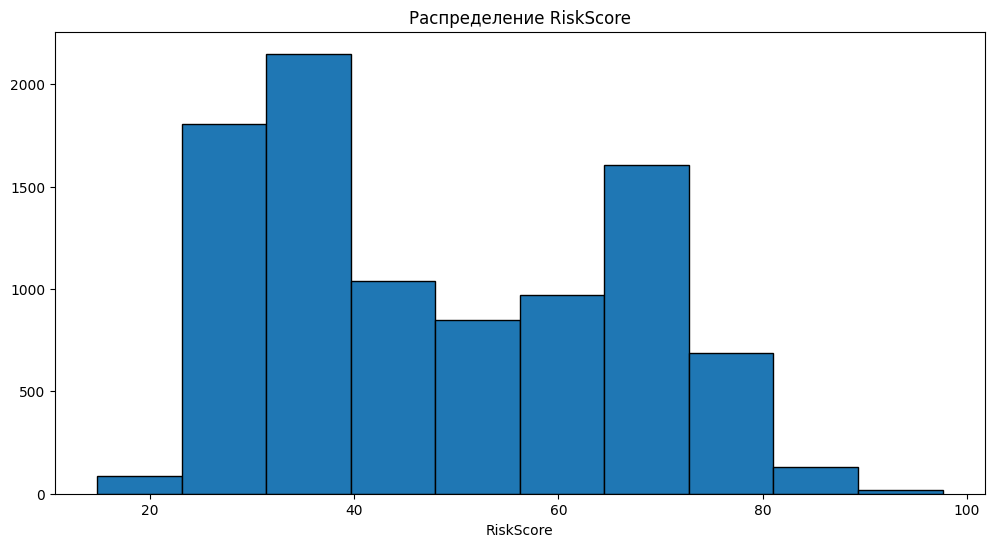

In [6]:
train_df = train_df[(train_df['RiskScore'] >= 0) & (train_df['RiskScore'] <= 99)]
plt.figure(figsize=(12,6))
plt.hist(train_df['RiskScore'], ec='k')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.show()

Нужно пребразовать категориальные признаки каким-либо энкодингом. Посмотрим сначала на сами признаки

In [7]:
categorical_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

for feature in categorical_features:
    print(f"{feature}: {train_df[feature].unique()}")

MaritalStatus: ['Divorced' 'Widowed' 'Married' 'Single']
HomeOwnershipStatus: ['Rent' 'Mortgage' 'Other' 'Own']
LoanPurpose: ['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']
EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed']
EducationLevel: ['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Столбцы, категории которого не имеют естественного порядка (MaritalStatus, HomeOwnershipStatus, LoanPurpose, EmploymentStatus) преобразуем One-Hot Encoding'ом. EducationLevel преобразуем Label Encoding'ом, так как тут явно упорядочен

In [8]:
def restruct(value):
    if value == "High School":
        return "A"
    elif value == "Bachelor":
        return "B"
    elif value == "Associate":
        return "C"
    elif value == "Master":
        return "D"
    elif value == "Doctorate":
        return "E"
    else:
        return "A"

train_df["EducationLevel"] = LabelEncoder().fit_transform(train_df["EducationLevel"].apply(restruct))
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
print('Формат тренировочной выборки: ', train_df.shape)

Формат тренировочной выборки:  (9332, 47)


Давайте построим HeatMap по всем признакам, исключив ApllicationDate. Хотелось бы выявить список признаков, которые будем использовать для обучения

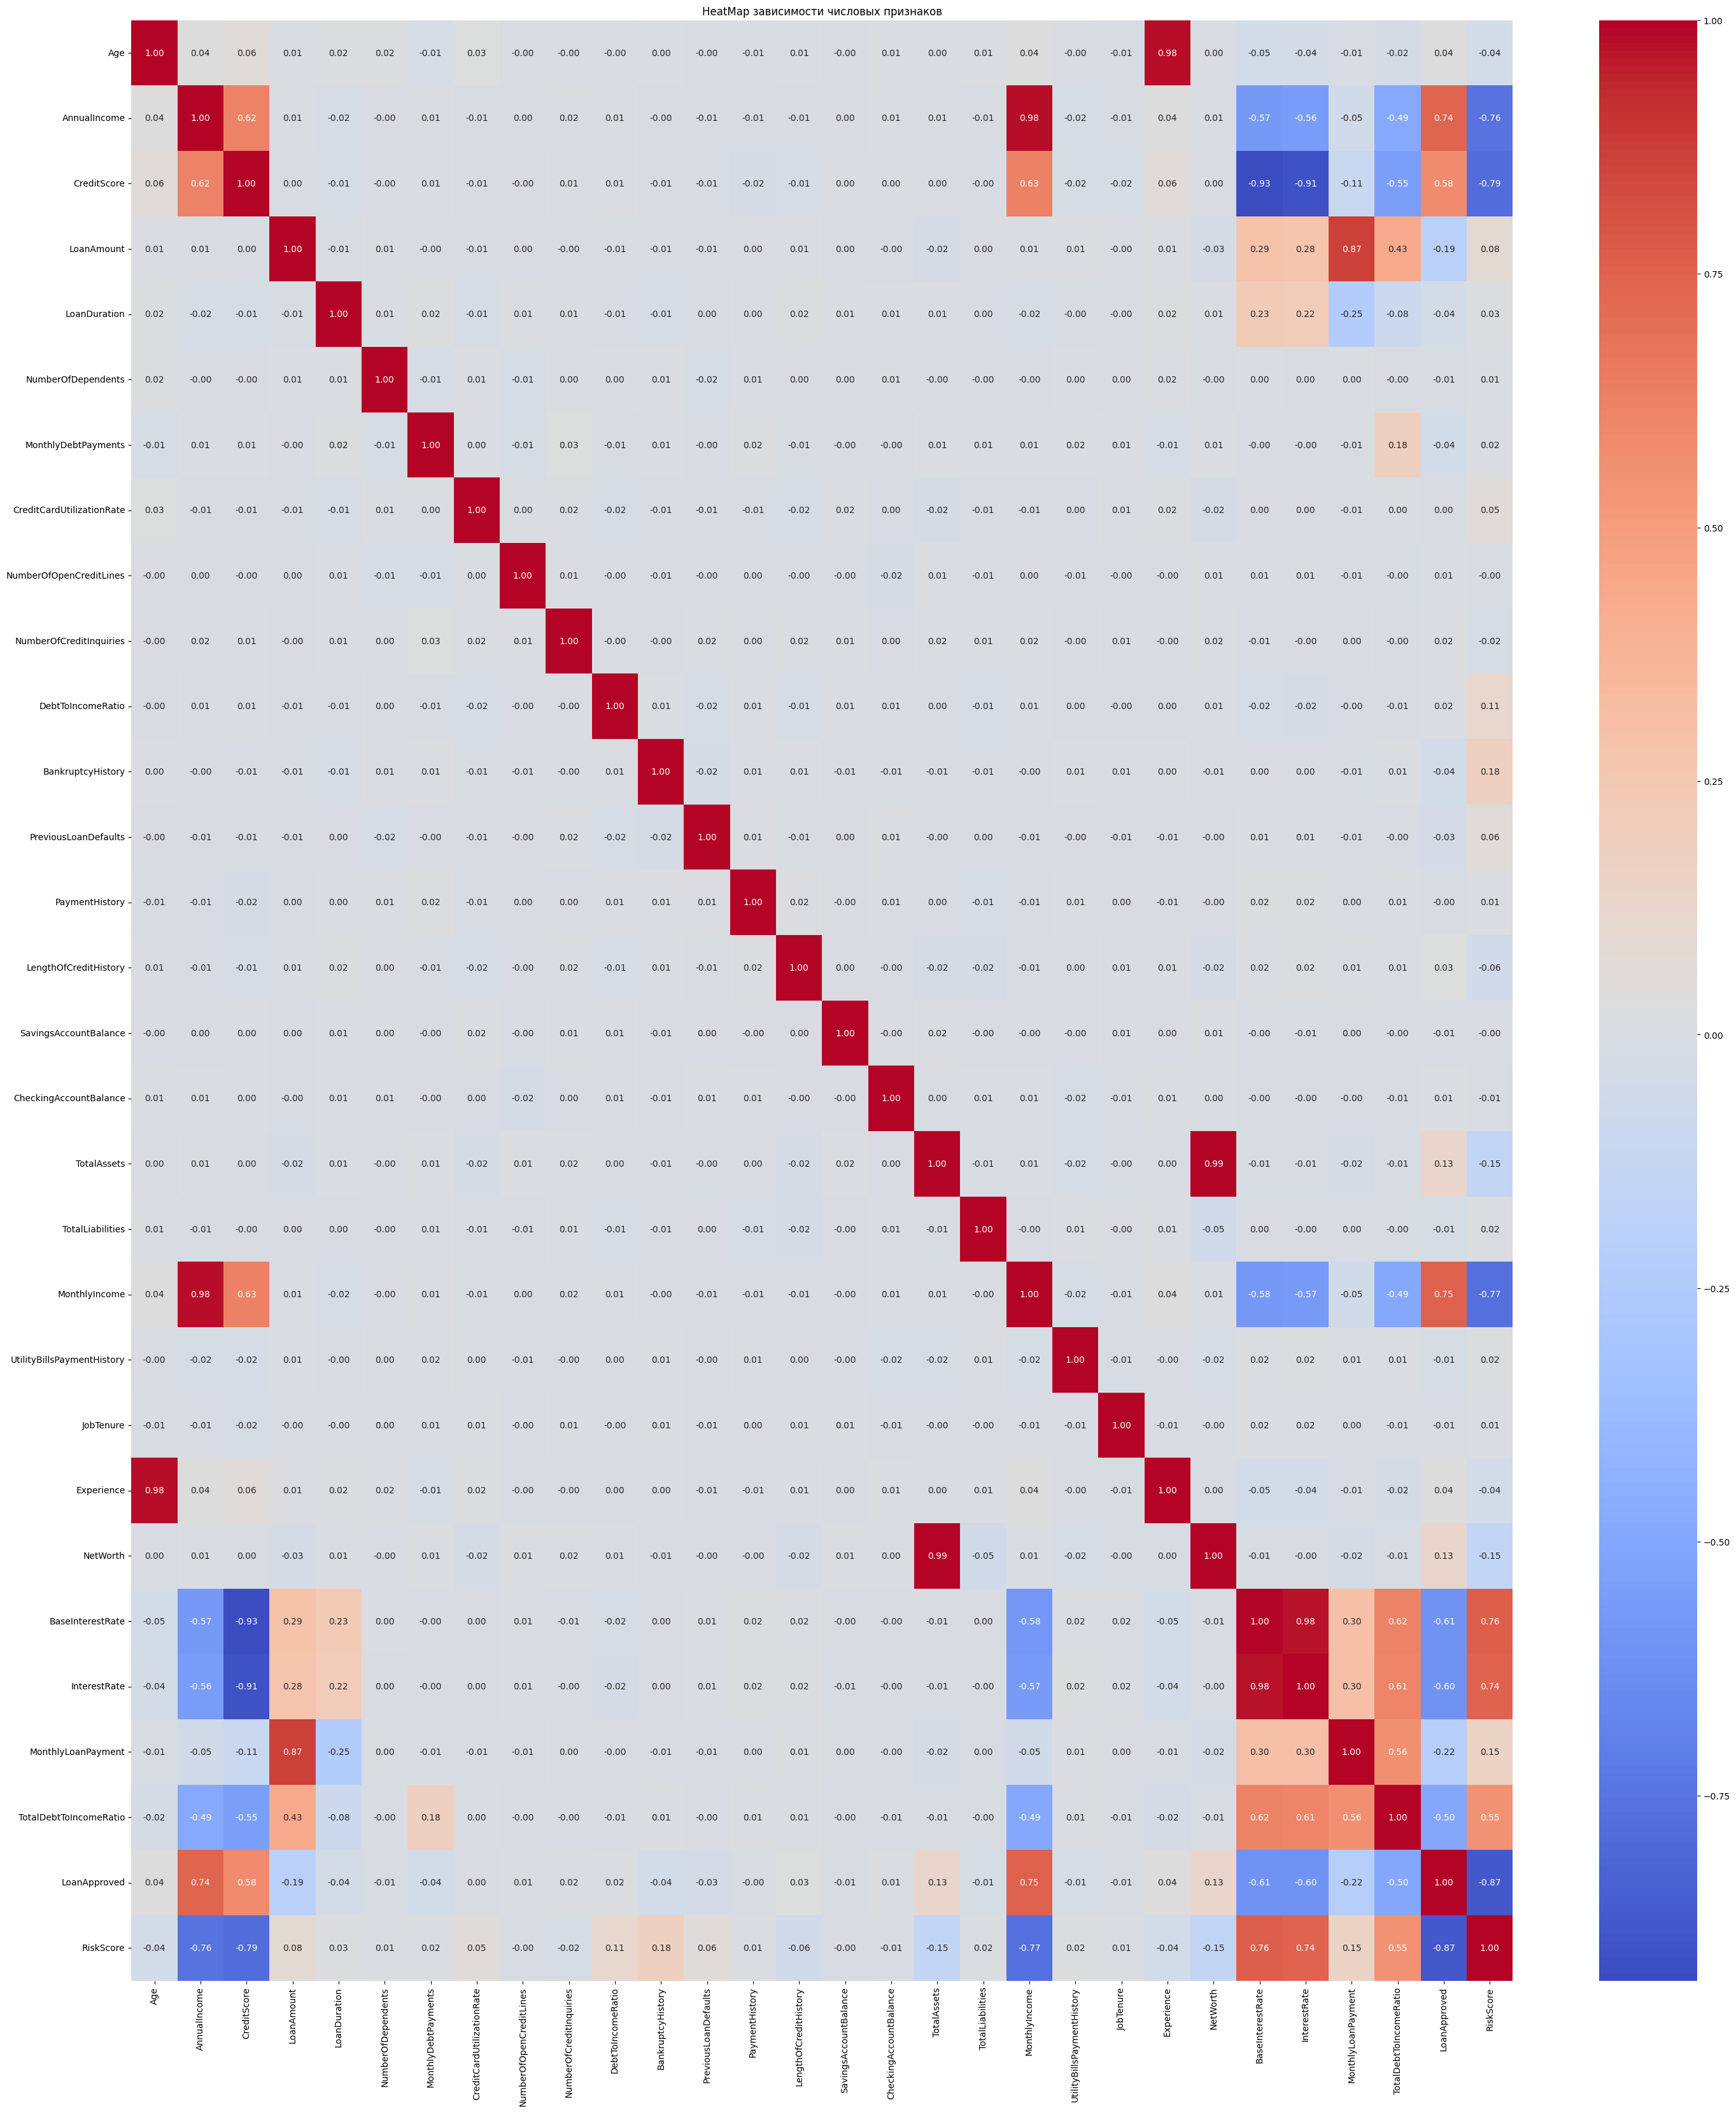

In [9]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(35, 40))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("HeatMap зависимости числовых признаков")
plt.show()

Проанализируем, какие признаки не сильно коррелируют с таргетом (~0), какие слишком сильно корреллируют, давая избыточную информацию (>80, <-80), можно понять, какие признаки всё таки нужно взять во внимание и в дальнейшем использовать для обучения моделей

In [10]:
selected_features = [
    'CreditScore', 'LoanDuration', 'MonthlyDebtPayments', 'BankruptcyHistory',
    'PreviousLoanDefaults', 'LengthOfCreditHistory', 'MonthlyIncome', 'NetWorth', 'TotalAssets',
    'BaseInterestRate', 'LoanAmount', 'AnnualIncome', 'InterestRate',
    'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore']

Создадим свою логистическую регрессию

In [11]:
class CustomModel:
    def __init__(self, lr=0.01, epochs=1000, mode='linear'):
        self.lr = lr
        self.epochs = epochs
        self.mode = mode
        self.params = None
        self.intercept = None

    def _activation(self, z):
        if self.mode == 'logistic':
            return 1 / (1 + np.exp(-z))
        return z

    def _update_params(self, grad_w, grad_b):
        self.params -= self.lr * grad_w
        self.intercept -= self.lr * grad_b

    def _compute_gradients(self, X, y_pred, y):
        grad_w = (1 / X.shape[0]) * np.dot(X.T, (y_pred - y))
        grad_b = (1 / X.shape[0]) * np.sum(y_pred - y)
        return grad_w, grad_b

    def fit(self, features, target):
        num_samples, num_features = features.shape
        self.params = np.zeros(num_features)
        self.intercept = 0

        for _ in range(self.epochs):
            model_output = np.dot(features, self.params) + self.intercept
            predictions = self._activation(model_output)

            grad_w, grad_b = self._compute_gradients(features, predictions, target)
            self._update_params(grad_w, grad_b)

    def predict(self, features):
        model_output = np.dot(features, self.params) + self.intercept
        predictions = self._activation(model_output)

        if self.mode == 'logistic':
            return np.where(predictions >= 0.5, 1, 0)
        return np.where(model_output >= 0.5, 1, 0)


Функция для оценки метрик и визуализации

In [12]:
def evaluate(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

    print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return metrics

Выборка из наиболее подходящих признаков и обучение на ней. 

In [13]:
train_data = train_df[selected_features].copy(deep=True)

In [14]:
X = train_data[selected_features]
y = train_df['LoanApproved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Подсчёт и визуализация

Metrics for Custom Linear Regression:
  Precision: 0.9778
  Recall: 0.9851
  F1-Score: 0.9814
  Accuracy: 0.9813


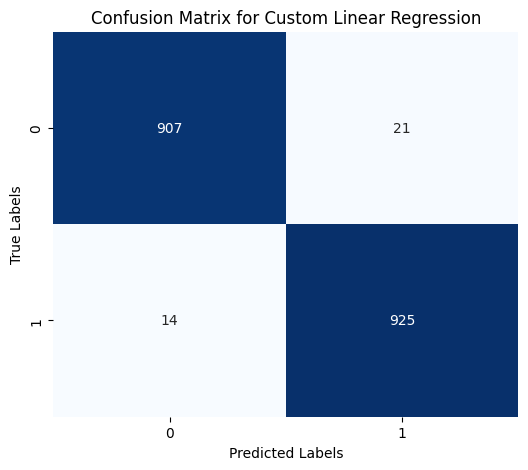

{'Precision': 0.9778012684989429,
 'Recall': 0.9850905218317358,
 'F1-Score': 0.9814323607427056,
 'Accuracy': 0.9812533476164971}

In [15]:
logistic_model = CustomModel()
logistic_model.fit(X_train_scaled, y_train)

y_pred_logistic = logistic_model.predict(X_test_scaled)
evaluate(y_test, y_pred_logistic, "Custom Linear Regression")

Metrics for Custom Logistic Regression:
  Precision: 0.9423
  Recall: 0.9574
  F1-Score: 0.9498
  Accuracy: 0.9491


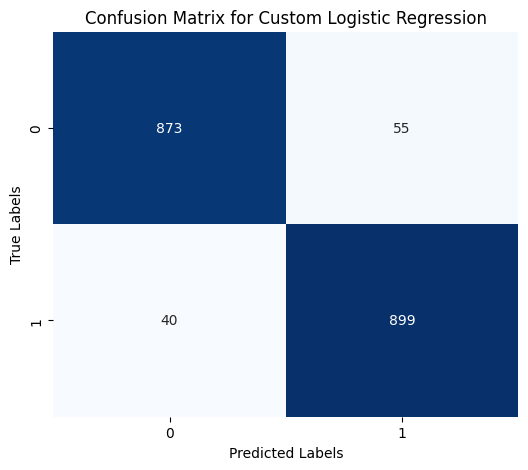

{'Precision': 0.9423480083857443,
 'Recall': 0.9574014909478168,
 'F1-Score': 0.9498151082937136,
 'Accuracy': 0.9491162292447777}

In [16]:
logistic_model = CustomModel(mode='logistic')
logistic_model.fit(X_train_scaled, y_train)

y_pred_logistic = logistic_model.predict(X_test_scaled)
evaluate(y_test, y_pred_logistic, "Custom Logistic Regression")

Metrics for SKLearn Logistic Regression:
  Precision: 0.9852
  Recall: 0.9936
  F1-Score: 0.9894
  Accuracy: 0.9893


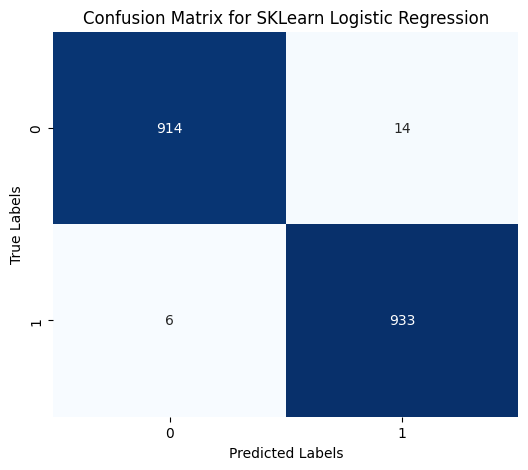

{'Precision': 0.9852164730728616,
 'Recall': 0.9936102236421726,
 'F1-Score': 0.9893955461293743,
 'Accuracy': 0.9892876272094269}

In [17]:
model_log_reg_sklearn = LogisticRegression()
model_log_reg_sklearn.fit(X_train_scaled, y_train)

y_pred_log_reg_sklearn = model_log_reg_sklearn.predict(X_test_scaled)

evaluate(y_test, y_pred_log_reg_sklearn, "SKLearn Logistic Regression")

Metrics for SVM:
  Precision: 0.9873
  Recall: 0.9915
  F1-Score: 0.9894
  Accuracy: 0.9893


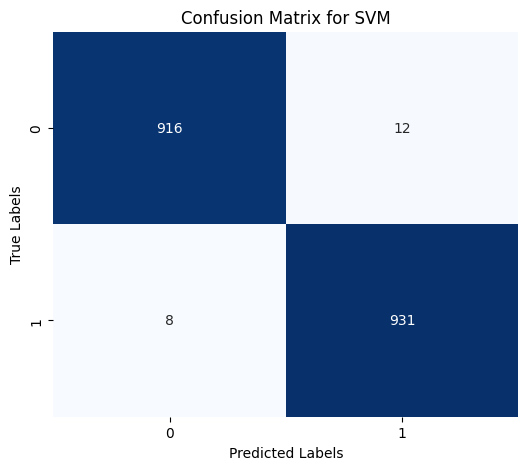

{'Precision': 0.9872746553552492,
 'Recall': 0.9914802981895634,
 'F1-Score': 0.9893730074388948,
 'Accuracy': 0.9892876272094269}

In [20]:
model_SVM = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
model_SVM.fit(X_train_scaled, y_train)

y_pred_svm = model_SVM.predict(X_test_scaled)

evaluate(y_test, y_pred_svm, "SVM")

Metrics for Decision Tree:
  Precision: 0.9852
  Recall: 0.9894
  F1-Score: 0.9872
  Accuracy: 0.9871


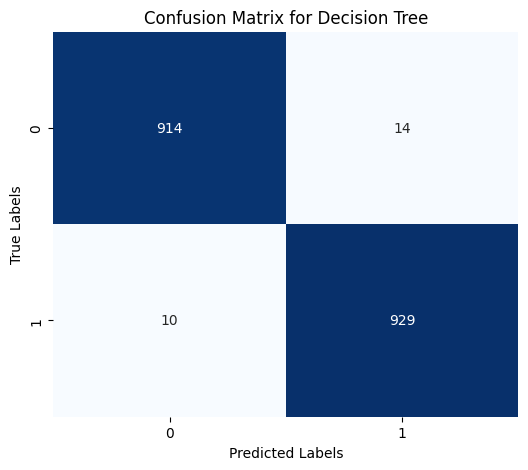

{'Precision': 0.985153764581124,
 'Recall': 0.9893503727369543,
 'F1-Score': 0.9872476089266737,
 'Accuracy': 0.9871451526513123}

In [308]:
model_DecisionTreeClassifier = DecisionTreeClassifier()
model_DecisionTreeClassifier.fit(X_train, y_train)

y_pred_model_DecisionTreeClassifier = model_DecisionTreeClassifier.predict(X_test)

evaluate(y_test, y_pred_model_DecisionTreeClassifier, "Decision Tree")

Metrics for Random Forest Classifier:
  Precision: 0.9800
  Recall: 0.9915
  F1-Score: 0.9857
  Accuracy: 0.9855


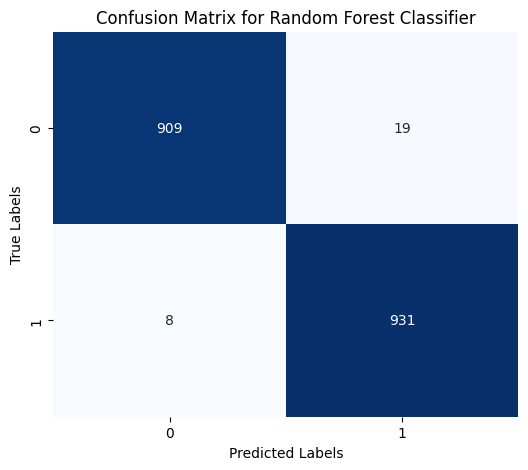

{'Precision': 0.98,
 'Recall': 0.9914802981895634,
 'F1-Score': 0.9857067231339333,
 'Accuracy': 0.9855382967327263}

In [309]:
model_RandomForestClassifier = RandomForestClassifier()
model_RandomForestClassifier.fit(X_train, y_train)

y_pred_model_RandomForestClassifier = model_RandomForestClassifier.predict(X_test)

evaluate(y_test, y_pred_model_RandomForestClassifier, "Random Forest Classifier")

Metrics for Sklearn Gradient Boosting:
  Precision: 0.9852
  Recall: 0.9957
  F1-Score: 0.9905
  Accuracy: 0.9904


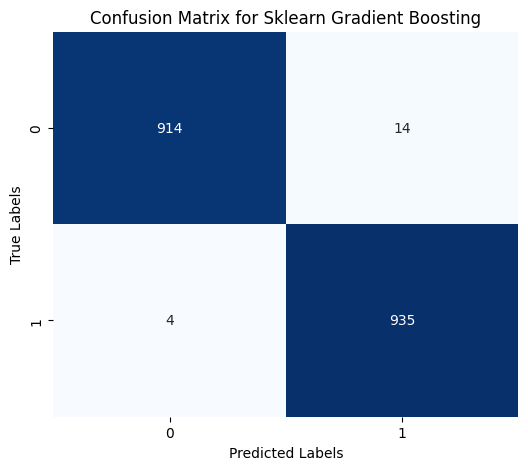

{'Precision': 0.9852476290832455,
 'Recall': 0.9957401490947817,
 'F1-Score': 0.9904661016949152,
 'Accuracy': 0.9903588644884842}

In [311]:
sklearn_gb_model = GradientBoostingClassifier(random_state=42)
sklearn_gb_model.fit(X_train, y_train)

y_pred_sklearn_gb = sklearn_gb_model.predict(X_test)

evaluate(y_test, y_pred_sklearn_gb, "Sklearn Gradient Boosting")

[LightGBM] [Info] Number of positive: 3850, number of negative: 3615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 7465, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515740 -> initscore=0.062981
[LightGBM] [Info] Start training from score 0.062981
Metrics for LightGBM:
  Precision: 0.9915
  Recall: 0.9957
  F1-Score: 0.9936
  Accuracy: 0.9936


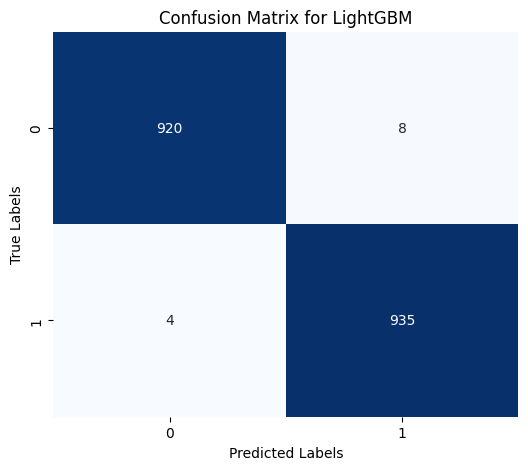

{'Precision': 0.9915164369034994,
 'Recall': 0.9957401490947817,
 'F1-Score': 0.9936238044633369,
 'Accuracy': 0.9935725763256561}

In [312]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

evaluate(y_test, y_pred_lgb, "LightGBM")

Metrics for XGBoost:
  Precision: 0.9905
  Recall: 0.9947
  F1-Score: 0.9926
  Accuracy: 0.9925


/home/parker/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


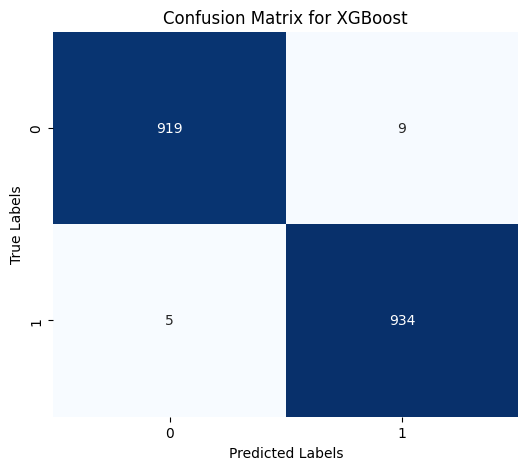

{'Precision': 0.9904559915164369,
 'Recall': 0.9946751863684771,
 'F1-Score': 0.9925611052072264,
 'Accuracy': 0.9925013390465989}

In [313]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

evaluate(y_test, y_pred_xgb, "XGBoost")

Metrics for CatBoost:
  Precision: 0.9926
  Recall: 0.9968
  F1-Score: 0.9947
  Accuracy: 0.9946


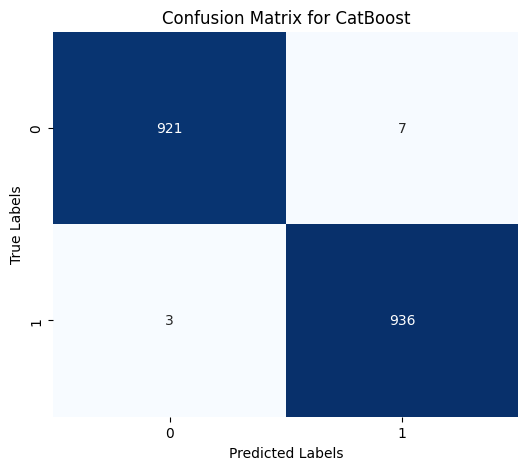

{'Precision': 0.9925768822905621,
 'Recall': 0.9968051118210862,
 'F1-Score': 0.9946865037194474,
 'Accuracy': 0.9946438136047134}

In [314]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)

evaluate(y_test, y_pred_catboost, "CatBoost")

Metrics for K-Nearest Neighbors:
  Precision: 0.8980
  Recall: 0.9095
  F1-Score: 0.9037
  Accuracy: 0.9025


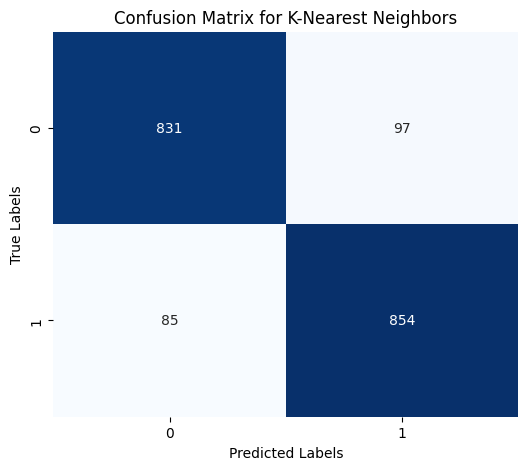

{'Precision': 0.8980021030494216,
 'Recall': 0.9094781682641108,
 'F1-Score': 0.9037037037037037,
 'Accuracy': 0.9025174076057847}

In [315]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

evaluate(y_test, y_pred_knn, "K-Nearest Neighbors")

Metrics for Naive Bayes:
  Precision: 0.9530
  Recall: 0.8850
  F1-Score: 0.9177
  Accuracy: 0.9202


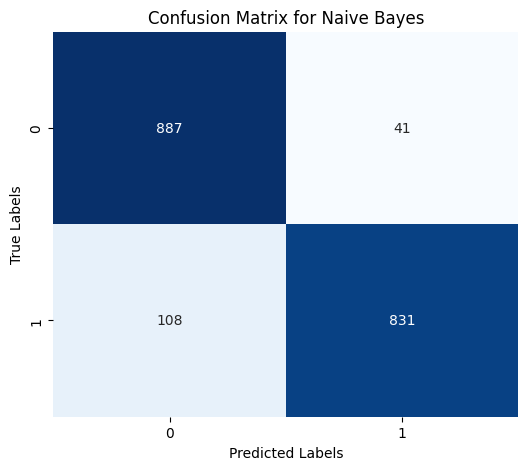

{'Precision': 0.9529816513761468,
 'Recall': 0.8849840255591054,
 'F1-Score': 0.9177250138045279,
 'Accuracy': 0.9201928227102303}

In [316]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

evaluate(y_test, y_pred_nb, "Naive Bayes")

/home/parker/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Metrics for AdaBoost:
  Precision: 0.9926
  Recall: 0.9947
  F1-Score: 0.9936
  Accuracy: 0.9936


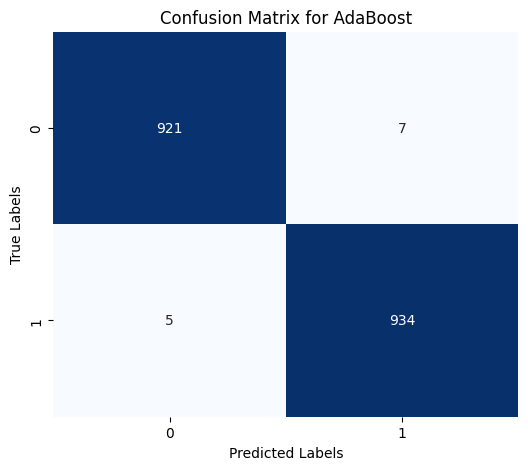

{'Precision': 0.9925611052072264,
 'Recall': 0.9946751863684771,
 'F1-Score': 0.9936170212765958,
 'Accuracy': 0.9935725763256561}

In [317]:
adaboost_model = AdaBoostClassifier(random_state=42, n_estimators=100)
adaboost_model.fit(X_train, y_train)

y_pred_adaboost = adaboost_model.predict(X_test)

evaluate(y_test, y_pred_adaboost, "AdaBoost")

## ВЫВОД
Анализируя показатели метрик, можно сказать, что в данной задаче бинарной классификации наиболее эффективными оказались ансамблевые методы, такие как градиентные бустинги. F1-Score оказался наиболее информативной метрикой для оценки моделей, так как она учитывает как точность, так и полноту. Если говорить о самых точных методах, то градиентный бустинг CatBoost с показателем F1-score равным 0,9946 показал наилучшие результаты благодаря своей устойчивости к переобучению. В этой задаче в качестве предобработки я убрал все пустые и частично пустые строки, что в целом не сказалось на результаты, но если бы удаление таких строк не предоставлялось бы возможным, то стоит знать, что CatBoost автоматически обрабатывает пропущенные значения и включает регуляризацию, что помогает избежать переобучения и улучшает обобщающую способность модели. А ещё CatBoost использует эффективные алгоритмы построения деревьев, такие как симметричное дерево (oblivious trees), что ускоряет обучение и улучшает точность. Второе место разделяет AdaBoost и LightGBM, с показателем F1 = 0.9936 и XGBoost c F1 = 0.9925. Decision Tree, SVM, Random Forest немного отстают от ансамблевых методов, но показатели в целом не так уж и плохи.
Пользовательские решения показали приемлимые результаты, по большей части сравнимые с результатами методик из SKlearn. 
КNN и наивные Байесовские классификаторы показали плохие результаты, так как KNN требует нормализации данных, иначе признаки с большими значениями будут доминировать, а Наивный Байес предполагает независимость признаков, что, ожидаемо, часто не выполняется в реальных данных, что мы и увидели здесь.